In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

In [2]:
!mkdir Hurricane_Harvey 
!mkdir Hurricane_Harvey/rasters Hurricane_Harvey/vectors 
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/rasters/raw Hurricane_Harvey/rasters/ 
!gsutil -m cp -n -r gs://geoengine-dataset-houston-uav/vectors/random-split-_2022_11_17-22_35_45/ Hurricane_Harvey/vectors/

Copying gs://geoengine-dataset-houston-uav/rasters/raw/10170.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10171.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10172.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10174.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10184.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10808.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10814.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10566.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10810.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10300.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10812.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/6414.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/6416.tif...
Copying gs://geoengine-dataset-houston-uav/rasters/raw/10817.tif...
Copying gs://geoengine-dataset-houston-uav/rasters

In [3]:
import os
import shutil
!mkdir data
!mkdir data/train_images data/test_images data/train_masks

In [4]:
# I'm moving all the files into a data folder containing 3 folders: train images, train masks and test images by storing the images id in
# 3 lists

mask_files = []
train_files = []
test_files = []

for filename in os.listdir('/content/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks'):
  mask_files.append(filename[:filename.find('.')])

for filename in os.listdir('/content/Hurricane_Harvey/rasters/raw'):
  if filename[:filename.find('.')] in mask_files:
    train_files.append(filename[:filename.find('.')])
  else:
    test_files.append(filename[:filename.find('.')])

for mask in mask_files:
    new_path = 'data/train_masks/' + mask +'.png'
    shutil.move('/content/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks/'+mask+'.png', new_path)

for train in train_files:
    new_path = 'data/train_images/' + train +'.tif'
    shutil.move('/content/Hurricane_Harvey/rasters/raw/'+train+'.tif', new_path)

for test in test_files:
    new_path = 'data/test_images/' + test +'.tif'
    if test != 'random-split-_2022_11_17-22_35_4':
      shutil.move('/content/Hurricane_Harvey/rasters/raw/'+test+'.tif', new_path)

In [5]:
# Specify paths of training, testing, and training mask files
# We are using the glob module to find all files in the /data/train_images/ directory that match the pattern 
# '/content/data/train_images/*'. The glob.glob() function returns a list of file paths that match the given pattern, and the sorted() function 
# is then used to sort that list alphabetically. 

train_link  = sorted(glob.glob('/content/data/train_images/*'))
train_mask_link = sorted(glob.glob('/content/data/train_masks/*'))
test_link   = sorted(glob.glob('/content/data/test_images/*'))

mask_files.sort()
train_files.sort()

In [6]:
# I create a dataframe to store all the ids of the train images in order to split efficiently the images between train and validation sets

def create_df():
    name = []
    for dirname, _, filenames in os.walk('/content/data/train_images/'):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  299


In [7]:
# 85% of the data for training and 15% for testing

X_train, X_val = train_test_split(df['id'].values, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

Train Size   :  254
Val Size     :  45


Image Size (3000, 4000, 3)
Mask Size (3000, 4000)


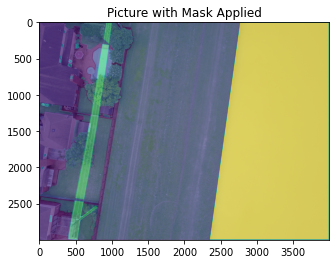

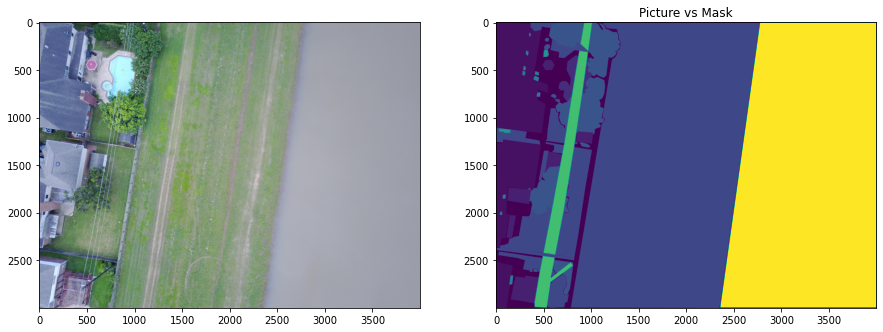

In [8]:
# I display the picture with mask applied to it

img = Image.open('/content/data/train_images/' + df['id'][100] + '.tif')
mask = Image.open('/content/data/train_masks/' + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Applied')
plt.show()

f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(img)
plt.title('Picture vs Mask')
axarr[1].imshow(mask)
plt.show()

In [9]:
class tensorDataset(Dataset):

    # The dataset takes in several parameters in its constructor, including the paths to image and mask files, a list of image file names,
    #  means and standard deviations for normalizing the image data, a flag to indicate whether or not the data is for training, and an optional 
    # transform to apply to the images and masks.
    
    def __init__(self, img_path, mask_path, X, mean, std, train, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        self.train = train
        
    # Length of the list of image file names
    def __len__(self):
        return len(self.X)
    
    # The image and mask are read from file, converted to RGB color space, and transformed (if a transform is provided). The image is 
    # then converted to a PyTorch tensor and normalized using the provided means and standard deviations, and the mask is converted to a 
    # PyTorch tensor of long data type. If the data is for training, random data augmentation is applied to the image and mask. 
    # If the patches flag is set to True, the image and mask are divided into smaller patches.
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)

        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.train == True:
          img, mask = self.transform(img, mask)
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask

    # Takes the image and mask and divides them into smaller patches of size 512x768
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    
    # Applies random data augmentation to the image and mask, including darkening, brightening, horizontal flipping, vertical flipping, 
    # and rotating
    def transform(self, img, mask):
        temp_rand = np.random.rand()
        if temp_rand < 0.3:
            t_darken_image = T.ColorJitter(brightness=[0.6, 0.8])
            img = t_darken_image(img)
        elif temp_rand > 0.7:
            t_brighten_image = T.ColorJitter(brightness=[1.2, 1.4])
            img = t_brighten_image(img)
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)
            mask = t_horizonal_flip(mask) 
        if np.random.rand() < 0.3:
            t_vertical_flip = T.RandomVerticalFlip(p=1)
            img  = t_vertical_flip(img)
            mask = t_vertical_flip(mask)
        if np.random.rand() < 0.3:
          t_rotation = T.RandomRotation(degrees=(0, 180))
          img = t_rotation(img)
          mask = t_rotation(mask)
        return img, mask

In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()]) # set of transformations for training set

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)]) # set of transformations for validation set

# Datasets
train_set = tensorDataset('/content/data/train_images/', '/content/data/train_masks/', X_train, mean, std, train = False, transform = t_train, patch=False)
val_set = tensorDataset('/content/data/train_images/', '/content/data/train_masks/',  X_val, mean, std, train = False, transform= t_val, patch=False)

# Dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [11]:
# Check if you are running on GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [12]:
# First algorithm we tried

import torch.nn as nn

class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)    
      
class unet_model(nn.Module):
    def __init__(self,out_channels=27,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)

    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [13]:
# We used a bunch of architectures using this library:
# Unet: resnet34, resnext50_32x4d with and without softmax, resnext101_32x4d with and without softmax
# DeepLabV3: resnext50_32x4d with and without softmax, resnext101_32x4d with and without softmax
# PSPNET: resnet101 with and without softmax

!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [14]:
# model = smp.PSPNet(
#     encoder_name = 'resnet101', 
#     encoder_weights = 'imagenet', 
#     classes = 27, 
#     activation = None, 
# ).to(device)
# model = smp.Unet('resnet34', encoder_weights='imagenet', classes=27, activation='softmax2d', encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model = smp.DeepLabV3('resnext50_32x4d', encoder_weights='imagenet', classes=27, activation='softmax2d', encoder_depth=5)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [15]:
# Takes in the model's output and the ground truth mask as input, and calculates the proportion of pixels that have been correctly classified. 
# It does this by first taking the argmax of the output across the channel dimension, to obtain a predicted mask, and then compares it to the 
# ground truth mask. It then returns the proportion of pixels that have the same label in the predicted and ground truth masks.
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

# Takes in the model's output and the ground truth mask as input. It first applies softmax function to the output to obtain class probabilities. 
# Then it takes argmax of the class probabilities to obtain predicted mask. The function then loops over each class and calculates the intersection 
# over union (IoU) score for each class and returns the mean of IoU score across all classes.
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [16]:
# Retrieve the current learning rate of the optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache() # Free space in GPU
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = [] 
    train_acc = []
    lrs = []
    min_loss = np.inf # set loss to infinity
    decrease = 1 
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        # Training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # Training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            # Forward
            output = model(image)
            loss = criterion(output, mask)
            # Evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            # Backward
            loss.backward()
            optimizer.step() # Update weight          
            optimizer.zero_grad() # Reset gradient
            
            # Step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            # Validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    if patch:
                        n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    # Evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    # Calculate loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            # Calculating mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 2 == 0:
                    print('saving model...')
                    torch.save(model.state_dict(), 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} times')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            # Print all the metrics of Training and Validation sets
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched, patch = False)

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.869 
saving model...
Epoch:1/15.. Train Loss: 3.074.. Val Loss: 2.869.. Train mIoU:0.068.. Val mIoU: 0.100.. Train Acc:0.411.. Val Acc:0.558.. Time: 6.68m


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 2.869 >> 2.829 
Epoch:2/15.. Train Loss: 2.853.. Val Loss: 2.829.. Train mIoU:0.101.. Val mIoU: 0.100.. Train Acc:0.539.. Val Acc:0.547.. Time: 6.62m


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 2.841.. Val Loss: 2.911.. Train mIoU:0.100.. Val mIoU: 0.075.. Train Acc:0.524.. Val Acc:0.448.. Time: 6.62m


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/15.. Train Loss: 2.832.. Val Loss: 2.957.. Train mIoU:0.103.. Val mIoU: 0.066.. Train Acc:0.528.. Val Acc:0.402.. Time: 6.61m


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 2.957 >> 2.782 
saving model...
Epoch:5/15.. Train Loss: 2.808.. Val Loss: 2.782.. Train mIoU:0.108.. Val mIoU: 0.108.. Train Acc:0.551.. Val Acc:0.577.. Time: 6.61m


  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
torch.save(model, 'Unet-Mobilenet.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [ ]:
model.to(device).load_state_dict(torch.load('/content/Unet-Mobilenet_v2_mIoU-0.173.pt'))

In [ ]:
from matplotlib import colors

# Define function for plotting images
def show_random_images(i, img, output, true_mask):
    # Get preiction from output
    pred_mask  = torch.argmax(output, dim=1)
    # Get one image/mask only from the list, based on passed index 'i'
    img = img[i].cpu()
    pred_mask = pred_mask[i].cpu()
    true_mask = true_mask[i].cpu()
    # Add dummy pixels in the top left <- ensures colors assigned to each class by matplotlib match in both masks
    for i in range(24):
      pred_mask[0][i] = i
      true_mask[0][i] = i
    # Plot
    f, axarr = plt.subplots(1,3, figsize=(25,20))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    axarr[1].imshow(true_mask, cmap='tab20')
    axarr[2].imshow(pred_mask, cmap='tab20')
    plt.show()

In [ ]:
# Print the images
for i, batch in enumerate(val_loader):
  img, mask = batch
  model.cpu()
  img = img
  output = model(img)
  show_random_images(0, img, output, mask)
  print(torch.unique(mask[0]))
  print(torch.unique(torch.argmax(output[0],dim = 0)))


In [ ]:
# I create a dataframe to store all the ids of the test images, in addition to storing their sizes

size_of_test_images = []

def create_df():
    name = []
    for dirname, _, filenames in os.walk('/content/data/test_images/'):
        for filename in sorted(filenames):
          size_of_test_images.append(Image.open('/content/data/test_images/'+filename).size)
          name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

In [ ]:
class testDataset(Dataset):
    
    def __init__(self, img_path, X, transform=None):
        self.img_path = img_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X['id'][idx] + '.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        return img


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = testDataset('/content/data/test_images/', df, transform=t_test)

In [ ]:
!mkdir test_preds

In [ ]:
from tqdm import tqdm
import cv2

model.cpu()
model.eval()
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]

# calculate output for each image in test set and save the prediction in new folder
for i in tqdm(range(75)):
  image = test_set[i]
  t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
  image = t(image)
  with torch.no_grad():
    image = image.unsqueeze(0)
    output = model(image)
    output = torch.argmax(output, dim=1).squeeze(0)
    output = np.uint8(output)
    output = Image.fromarray(output)
    output = cv2.resize(np.asarray(output,dtype='uint8'), (size_of_test_images[i][0], size_of_test_images[i][1]), interpolation = cv2.INTER_NEAREST)
    cv2.imwrite(f"/content/test_preds/{df['id'][i]}.png", output)

In [ ]:
count = 0
temp = sorted(glob.glob('/content/test_preds/*'))
for i in tqdm(range(len(temp))):
  if Image.open(temp[i]).size == size_of_test_images[i]:
    count = count + 1
print(count)

In [ ]:
import tarfile

tar = tarfile.open("nchala5.tar", "w")

for root, dir, files in os.walk('/content/test_preds'):
    for  file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()